In [4]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
BASE_DIR = ''
WORKING_DIR = 'working'


In [6]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [8]:
%pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [9]:
# extract features from image
features = {}
directory = 'Images'#os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [10]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [11]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [12]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [13]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [14]:
len(mapping)

8091

In [15]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
        # preprocessing steps
        # convert to lowercase
            caption = caption.lower()
        # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
            caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [16]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [17]:
# preprocess the text
clean(mapping)

In [18]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [19]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)

40455

In [20]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [21]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

vocab_size

8485

In [22]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]


In [24]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [25]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
# train the model
epochs = 20
batch_size = 35
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

208/208 [==============================] - 729s 4s/step - loss: 2.2012 - accuracy: 0.4430


In [26]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [29]:
%pip install rouge


In [30]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
rouge_scorer=Rouge()
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    sx=""
    sy=""
    for x in y_pred:
        sx=sx+x+" "
    for x in actual_captions[2]:
        sy=sy+x+" "
    score = rouge_scorer.get_scores(
    hyps=sx,
    refs=sy,
    )
    
    print("Rouge",score[0]["rouge-l"],"\n")
    # calcuate BLEU score
    
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
    print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

Rouge {'r': 0.07692307692307693, 'p': 0.5, 'f': 0.13333333102222228} 

BLEU-1: 0.027778
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


c:\Users\kumar\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\kumar\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\kumar\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

Rouge {'r': 0.2, 'p': 0.5, 'f': 0.2857142816326531} 

BLEU-1: 0.027778
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
Rouge {'r': 0.1, 'p': 0.3333333333333333, 'f': 0.15384615029585808} 

BLEU-1: 0.027778
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
Rouge {'r': 0.14285714285714285, 'p': 0.5, 'f': 0.22222221876543213} 

BLEU-1: 0.027778
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
Rouge {'r': 0.09090909090909091, 'p': 0.5, 'f': 0.1538461512426036} 

BLEU-1: 0.027778
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
Rouge {'r': 0.125, 'p': 0.5, 'f': 0.19999999680000002} 

BLEU-1: 0.027778
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
Rouge {'r': 0.08333333333333333, 'p': 0.5, 'f': 0.14285714040816327} 

BLEU-1: 0.027778
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
Rouge {'r': 0.1111111111111111, 'p': 0.5, 'f': 0.18181817884297521} 

BLEU-1: 0.027778
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
Rouge {'r': 0.1111111111111111, 'p': 0.5, 'f': 0.181818178842

In [31]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [33]:
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method of SentimentIntensityAnalyzer
# oject gives a sentiment dictionary.
# which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']
#     print("Overall sentiment dictionary is : ", sentiment_dict)
#     print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
#     print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
#     print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
#     print("Sentence Overall Rated As", end = " ")
#     # decide sentiment as positive, negative and neutral
#     if sentiment_dict['compound'] >= 0.05 :
#         print("Positive")
#     elif sentiment_dict['compound'] <= - 0.05 :
#         print("Negative")
#     else :
#         print("Neutral")

In [34]:
images = ["1000268201_693b08cb0e.jpg","1001773457_577c3a7d70.jpg","1002674143_1b742ab4b8.jpg","1003163366_44323f5815.jpg","1022454332_6af2c1449a.jpg","1075867198_27ca2e7efe.jpg","1077546505_a4f6c4daa9.jpg","109738763_90541ef30d.jpg","1124448967_2221af8dc5.jpg"]

In [41]:
for img_name in tqdm(os.listdir(directory)):
    images.append(img_name)
    y=y+1
    if y == x :
        break

print(images)

  0%|          | 0/8091 [00:00<?, ?it/s]

['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1007320043_627395c3d8.jpg', '1009434119_febe49276a.jpg', '1012212859_01547e3f17.jpg', '1015118661_980735411b.jpg', '1015584366_dfcec3c85a.jpg', '101654506_8eb26cfb60.jpg', '101669240_b2d3e7f17b.jpg', '1016887272_03199f49c4.jpg', '1019077836_6fc9b15408.jpg', '1019604187_d087bf9a5f.jpg', '1020651753_06077ec457.jpg', '1022454332_6af2c1449a.jpg', '1022454428_b6b660a67b.jpg', '1022975728_75515238d8.jpg', '102351840_323e3de834.jpg', '1024138940_f1fefbdce1.jpg', '102455176_5f8ead62d5.jpg', '1026685415_0431cbf574.jpg', '1028205764_7e8df9a2ea.jpg', '1030985833_b0902ea560.jpg', '103106960_e8a41d64f8.jpg', '103195344_5d2dc613a3.jpg', '103205630_682ca7285b.jpg', '1032122270_ea6f0beedb.jpg', '1032460886_4a598ed535.jpg', '1034276567_49bb87c51c.jpg', '104136873_5b5d41be75.jpg', '1042020065_fb3d3ba5ba.jpg', '1042590306_95dea0916c.jpg', '1045521051_108ebc19b

In [44]:
images=[]
x=50
y=0
for img_name in tqdm(os.listdir(directory)):
    images.append(img_name)
    y = y+1
    if(y==50):
        break

  0%|          | 0/8091 [00:00<?, ?it/s]

In [47]:
len(images)

50

In [48]:
from PIL import Image
import matplotlib.pyplot as plt
answer = ""
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    answer = y_pred
    plt.imshow(image)

In [54]:
features[images[5].split('.')[0]]

array([[0.       , 0.       , 0.       , ..., 0.       , 3.3390176,
        0.       ]], dtype=float32)

In [53]:
predict_caption(model, features[images[5].split('.')[0]], tokenizer, max_length)

'startseq cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue'

In [49]:
y_pred = []
y_true = []

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback horseback


TypeError: 'NoneType' object is not subscriptable

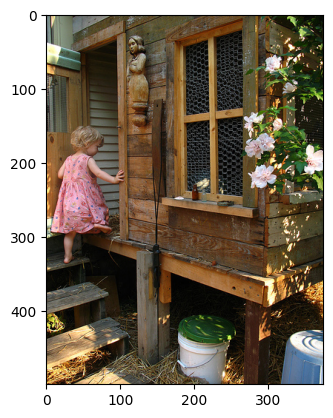

In [50]:
for image in images:
    y = generate_caption(image)
    if y[0] >= 0:
        y_pred.append(1)
    else :
        y_pred.append(0)
    if y[1] >= 0:
        y_true.append(1)
    else :
        y_true.append(0)
#     y_pred.append(y[0])
#     y_true.append(y[1])

---------------------Actual---------------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
--------------------Predicted--------------------
startseq cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue cue


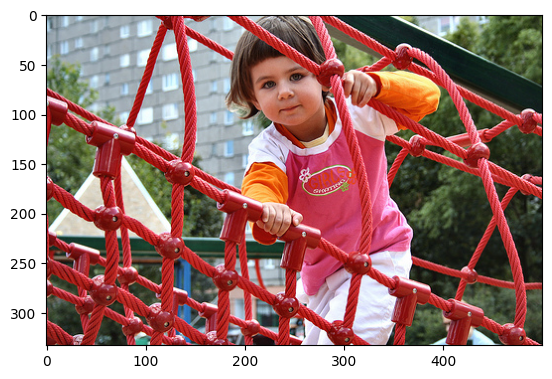

In [51]:
generate_caption(images[5])

In [78]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [79]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [80]:
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method of SentimentIntensityAnalyzer
# oject gives a sentiment dictionary.
# which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    print("Overall sentiment dictionary is : ", sentiment_dict)
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
    print("Sentence Overall Rated As", end = " ")
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negative")
    else :
        print("Neutral")

In [81]:
# Driver code
if __name__ == "__main__" :
    print("Text Selected for VADER Sentimental Analysis :")
    sentence1 = ('''boy in water screams''')
    print(sentence1)

Text Selected for VADER Sentimental Analysis :
boy in water screams


In [82]:
# function calling
sentiment_scores(sentence1)

Overall sentiment dictionary is :  {'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'compound': -0.296}
sentence was rated as  42.3 % Negative
sentence was rated as  57.699999999999996 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Negative


In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the true labels and predicted labels into arrays
y_true = [0, 0, 1, 1, 1, 1, 0, 0, 1, 0]
y_pred = [0, 0, 1, 1, 1, 0, 1, 1, 0, 0]

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: ", accuracy)

# Calculate the precision
precision = precision_score(y_true, y_pred, average='binary')
print("Precision: ", precision)

# Calculate the recall
recall = recall_score(y_true, y_pred, average='binary')
print("Recall: ", recall)


# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='binary')
print("F1 Score: ", f1)

# Calculate the confusion matrix
confusion_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix: \n", confusion_matrix)

Accuracy:  0.6
Precision:  0.6
Recall:  0.6
F1 Score:  0.6
Confusion Matrix: 
 [[3 2]
 [2 3]]
